# Notes

*   Variables are common between the different dimensionality methods so you desire to re-run a block of code make sure you re-run all previous code blocks of the corresponding method.
*   Datasets must be present be in the same directory as this notebook.
*   Output plots for every dimensionality reduction method exist in the folder `../output`.
*   The code resembles a pipeline but it actually analyzes the datasets and recommends visually the best parameters to be then handpicked.
*   Notebook developed on Google Colab

# Libraries

In [1]:
!pip install umap-learn

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn import mixture
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

%matplotlib inline
import matplotlib.pyplot as plt
import time
import seaborn as sns

*if your are not using Google Colab, ignore/remove the block below else modify it to match your Google Drive paths*

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir("drive/My Drive/Colab Notebooks/ML/Assignment2")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Datasets Import

In [4]:
data = []
for i in range(1,6):
    data.append(pd.read_csv("./dataset" + str(i) +".csv"))
    data[i-1] = data[i-1].drop(data[i-1].columns[0], axis=1)

# PCA

### Standardization

In [5]:
data_rescaled = []
for i in data:
    data_rescaled.append(StandardScaler().fit_transform(i))

Check if mean tends to zero and variance is 1.0:

In [6]:
print("Mean: " + str(np.mean(data_rescaled[0])))
print("Variance: " + str(np.std(data_rescaled[0])))

Mean: -1.1080025785759062e-17
Variance: 1.0


### Number of Components

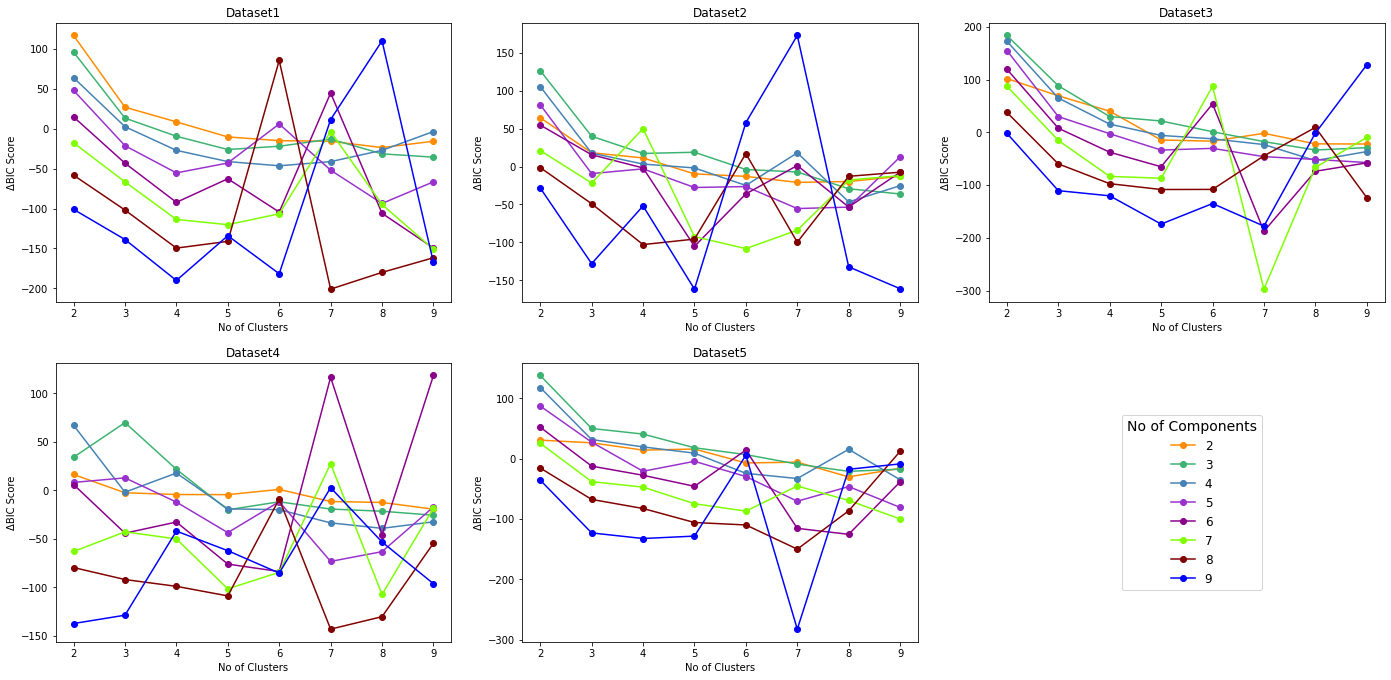

In [7]:
n_components = range(2,10)

# Plot the BIC scores
fig, ax = plt.subplots(2, 3 ,figsize=(20,10))
colormap = ['darkorange', 'mediumseagreen','steelblue','darkorchid','darkmagenta', 'chartreuse','maroon', 'blue']
fig.tight_layout(pad=4.0)
fig.delaxes(ax[1][2])

#LOOP Through datasets
for i in range(len(data_rescaled)):
    data_reduced = []

    if i < 3:
        plot_row = 0
        plot_col = i 
    else: 
        plot_row = 1
        plot_col = i - 3

    # LOOP through Components
    for j in range(len(n_components)):
        pca = PCA(n_components[j])
        pca.fit(data_rescaled[i])
        data_reduced.append(pca.transform(data_rescaled[i]))

        column_names = []
        for k in range(data_reduced[j].shape[1]):
            column_names.append('principal component ' + str(k))

        X = pd.DataFrame(data = data_reduced[j], columns = column_names)
        
        # Set up a range of cluster numbers to try
        n_range = range(2,11)
        # Create empty lists to store the BIC and AIC values
        bic_score = []
        # Loop through the range and fit a model
        for n in n_range:
            gm = mixture.GaussianMixture(n_components=n, random_state=123, n_init=10)
            gm.fit(X)
            # Append the BIC and AIC to the respective lists
            bic_score.append(gm.bic(X))

        delta_bic_score = []
        for x in range(len(bic_score)):
            if ( x == len(bic_score)-1):
                break
            delta_bic_score.append(bic_score[x] - bic_score[x+1])

            
        n_range = range(2,10)
        ax[plot_row][plot_col].plot(n_range, delta_bic_score, '-o', color=colormap[j], label=str(n_components[j]))

    ax[plot_row][plot_col].set(xlabel='No of Clusters', ylabel='ΔBIC Score')
    ax[plot_row][plot_col].set_xticks(n_range)    
    ax[plot_row][plot_col].set_title('Dataset'+ str(i + 1))
    if plot_row and plot_col:
        ax[plot_row][plot_col].legend(title = "No of Components", loc='center left', bbox_to_anchor=(1.5, 0.5), fontsize=12, title_fontsize=14)

Apply PCA to all datasets with the optimal number of principal components

In [8]:
opt_number_components = 4

data_reduced = []
for i in range(len(data_rescaled)):
    pca = PCA(n_components = opt_number_components)
    pca.fit(data_rescaled[i])
    data_reduced.append(pca.transform(data_rescaled[i]))

Transform to dataframes

In [9]:
  principalDf = []
  for i in range(len(data_reduced)):
    column_names = []

    for j in range(opt_number_components):
        column_names.append('principal component ' + str(j))
        
    principalDf.append(pd.DataFrame(data = data_reduced[i], columns = column_names))

### GMM

The best way to find an appropriate cluster number is to try different cluster numbers and see which fits your data appropriately.

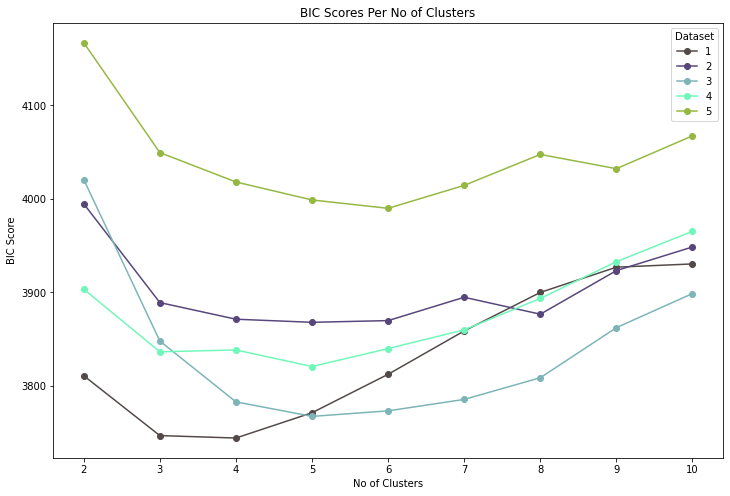

In [10]:
X = principalDf

# Set up a range of cluster numbers to try
n_range = range(2,11)
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
colormap = ['#524948', '#57467B','#7CB4B8','#70F8BA','#95b842']

for i in range(len(principalDf)):
    # Create empty lists to store the BIC and AIC values
    bic_score = []

    # Loop through the range and fit a model
    for n in n_range:
        gm = mixture.GaussianMixture(n_components=n, random_state=123, n_init=10)
        gm.fit(X[i])
        
        # Append the BIC and AIC to the respective lists
        bic_score.append(gm.bic(X[i]))

    # Plot the BIC scores
    ax.plot(n_range, bic_score, '-o', color=colormap[i], label = str(i+1))

ax.set(xlabel='No of Clusters', ylabel='BIC Score')
ax.set_xticks(n_range)
ax.set_title('BIC Scores Per No of Clusters')
ax.legend(title="Dataset")

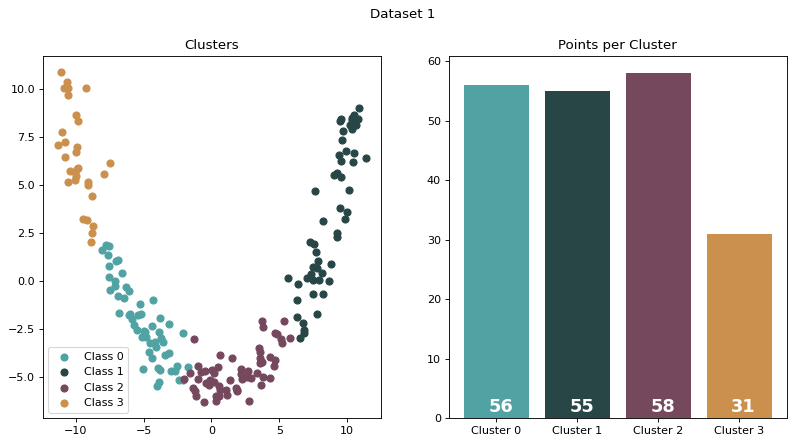

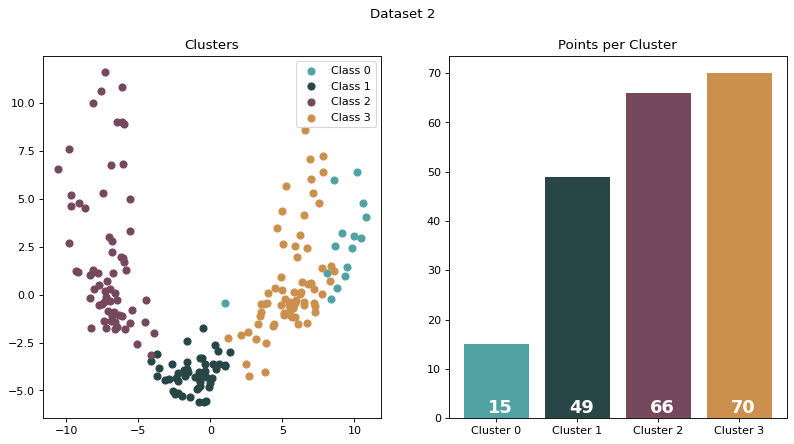

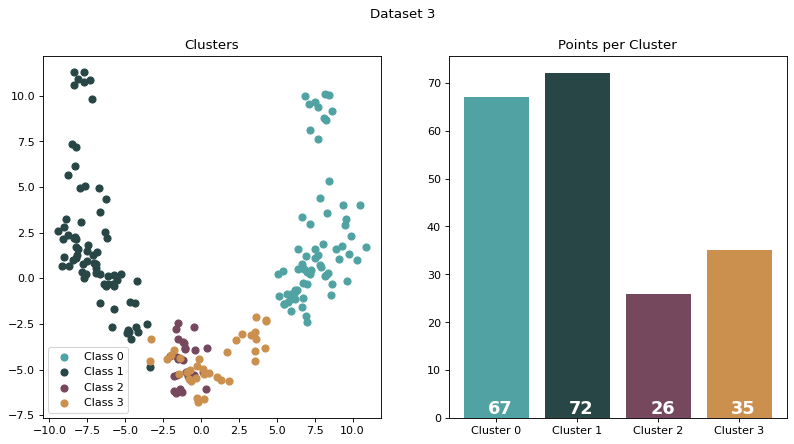

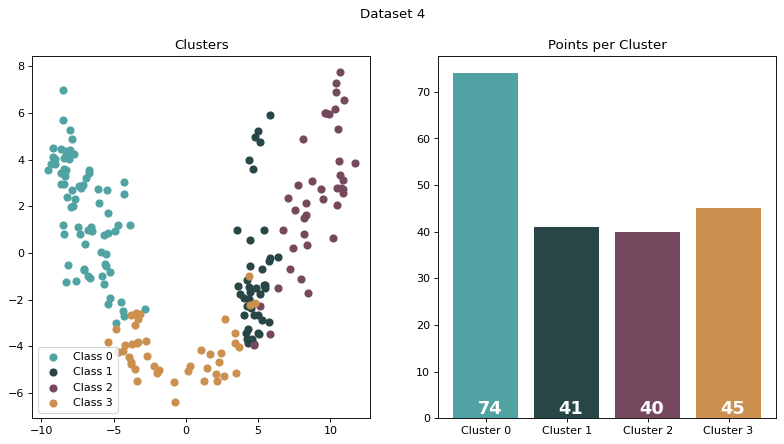

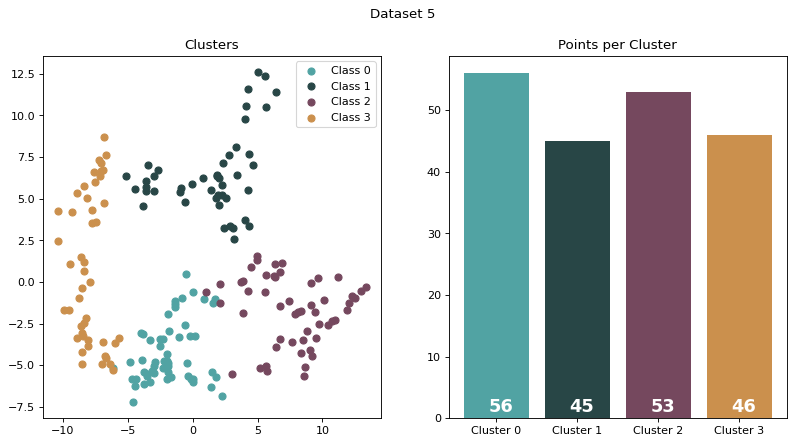

In [11]:
for index,X in enumerate(principalDf):
    gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=42).fit(X)
    # Assign a label to each sample 
    labels = gmm.predict(X) 
    X['labels']= labels 

    fig, axs = plt.subplots(1,2,figsize=(12, 6), dpi=80)

    myColorMap = ['#51A3A3', '#284646', '#75485E', '#CB904D']
    for i in range(4):
        X_array = np.array(X.loc[X['labels'] == i])
        axs[0].scatter(X_array[:, 0], X_array[:, 1], c=myColorMap[i], s=40, label = "Class "+str(i));
    axs[0].legend()
    axs[0].set_title("Clusters")

    d0 = X[X['labels']== 0] 
    d1 = X[X['labels']== 1] 
    d2 = X[X['labels']== 2] 
    d3 = X[X['labels']== 3]

    # Histogram Visualization
    values = [d0.shape[0], d1.shape[0],d2.shape[0], d3.shape[0]]
    classes = ('Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3')
    x_pos = np.arange(len(classes))
    # Create classes with different colors
    axs[1].bar(x_pos, values, color=myColorMap)
    # Create names on the x-axis
    axs[1].set_xticks(x_pos)
    axs[1].set_xticklabels(classes)
    axs[1].set_title("Points per Cluster")
    for i, bar in enumerate(values):
        plt.text(i-.10, 1 , bar, fontsize=16, color ='white', fontweight='bold')

    plt.suptitle("Dataset "+ str(index+1))
    plt.show()
    print("\n")

# TSNE

### Hypertuning: *perplexity*

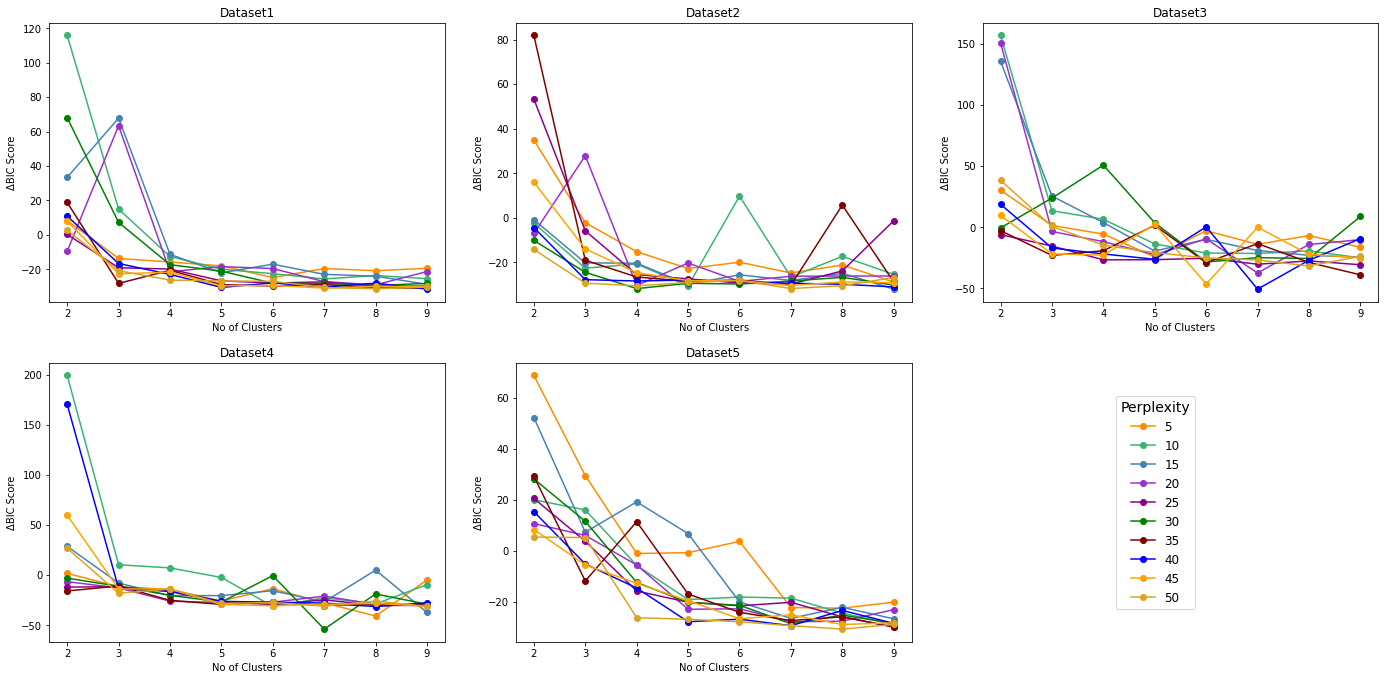

In [12]:
perplexities = range(5, 55, 5)

# Plot the BIC scores
fig, ax = plt.subplots(2, 3 ,figsize=(20,10))
colormap = ['darkorange', 'mediumseagreen','steelblue','darkorchid','darkmagenta', 'green','maroon', 'blue', 'orange', 'goldenrod', 'black']
fig.tight_layout(pad=4.0)
fig.delaxes(ax[1][2])

#LOOP Through datasets
for i in range(len(data)):
    data_reduced = []

    if i < 3:
        plot_row = 0
        plot_col = i 
    else: 
        plot_row = 1
        plot_col = i - 3

    # LOOP through Components
    for j in range(len(perplexities)):

        tsne = TSNE(n_components=2, perplexity=perplexities[j], n_iter=300)
        tsne_results = tsne.fit_transform(data[i])

        data_reduced.append(tsne_results)

        column_names = []
        for k in range(data_reduced[j].shape[1]):
            column_names.append('principal component ' + str(k))

        X = pd.DataFrame(data = data_reduced[j], columns = column_names)
        
        # Set up a range of cluster numbers to try
        n_range = range(2,11)
        # Create empty lists to store the BIC and AIC values
        bic_score = []
        # Loop through the range and fit a model
        for n in n_range:
            gm = mixture.GaussianMixture(n_components=n, random_state=123, n_init=10)
            gm.fit(X)
            # Append the BIC and AIC to the respective lists
            bic_score.append(gm.bic(X))

        delta_bic_score = []
        for x in range(len(bic_score)):
            if ( x == len(bic_score)-1):
                break
            delta_bic_score.append(bic_score[x] - bic_score[x+1])

        n_range = range(2,10)
        ax[plot_row][plot_col].plot(n_range, delta_bic_score, '-o', color=colormap[j], label=str(perplexities[j]))

    ax[plot_row][plot_col].set(xlabel='No of Clusters', ylabel='ΔBIC Score')
    ax[plot_row][plot_col].set_xticks(n_range)    
    ax[plot_row][plot_col].set_title('Dataset'+ str(i + 1))
    if plot_row and plot_col:
        ax[plot_row][plot_col].legend(title = "Perplexity", loc='center left', bbox_to_anchor=(1.5, 0.5), fontsize=12, title_fontsize=14)

Apply TSNE to all datasets with the optimal perplexity (=30)

In [13]:
opt_perplexity = 30

data_reduced = []
for i in range(len(data)):
    tsne = TSNE(n_components=2, perplexity=opt_perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(data[i])

    data_reduced.append(tsne_results)

Tranform to dataframes

In [14]:
  principalDf = []
  for i in range(len(data_reduced)):
    column_names = []

    for j in range(2):
        column_names.append('principal component ' + str(j))
        
    principalDf.append(pd.DataFrame(data = data_reduced[i], columns = column_names))

### GMM

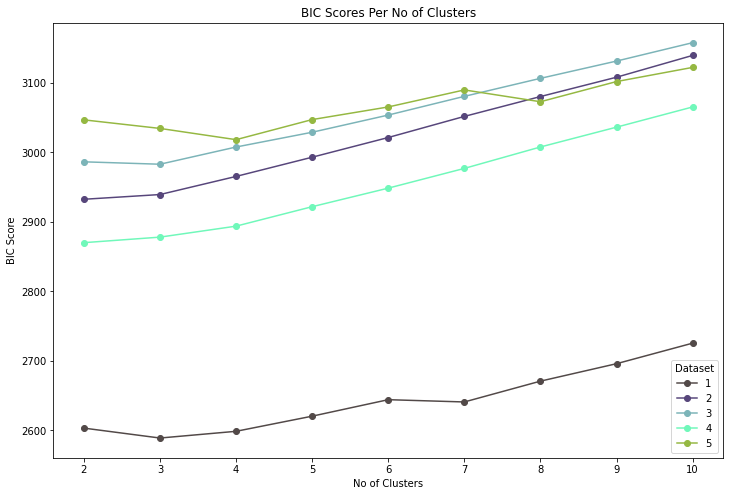

In [15]:
X = principalDf

# Set up a range of cluster numbers to try
n_range = range(2,11)
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
colormap = ['#524948', '#57467B','#7CB4B8','#70F8BA','#95b842']

for i in range(len(principalDf)):
    # Create empty lists to store the BIC and AIC values
    bic_score = []

    # Loop through the range and fit a model
    for n in n_range:
        gm = mixture.GaussianMixture(n_components=n, random_state=123, n_init=10)
        gm.fit(X[i])
        
        # Append the BIC and AIC to the respective lists
        bic_score.append(gm.bic(X[i]))

    # Plot the BIC scores
    ax.plot(n_range, bic_score, '-o', color=colormap[i], label = str(i+1))

ax.set(xlabel='No of Clusters', ylabel='BIC Score')
ax.set_xticks(n_range)
ax.set_title('BIC Scores Per No of Clusters')
ax.legend(title="Dataset")

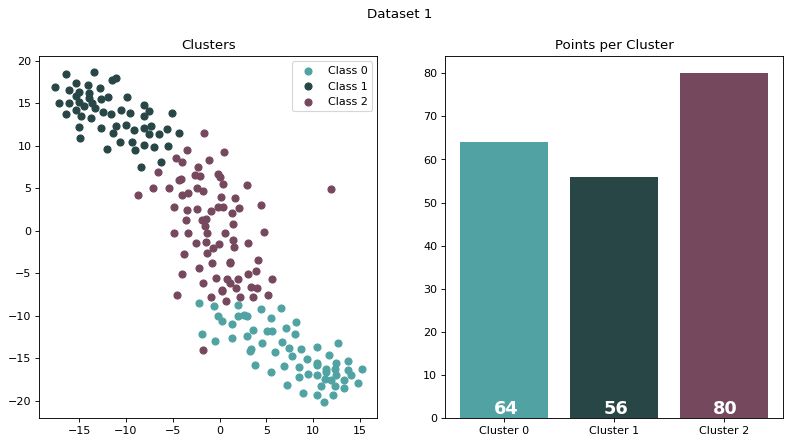

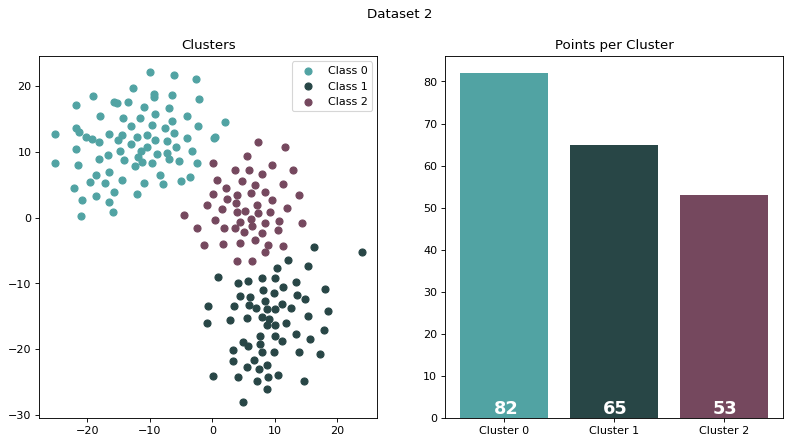

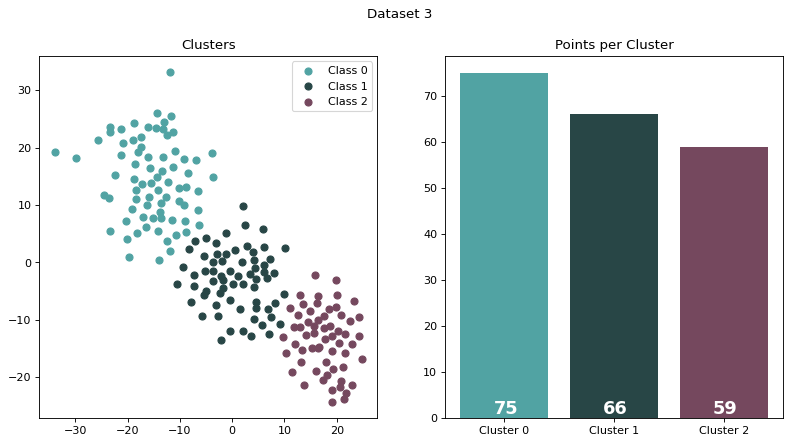

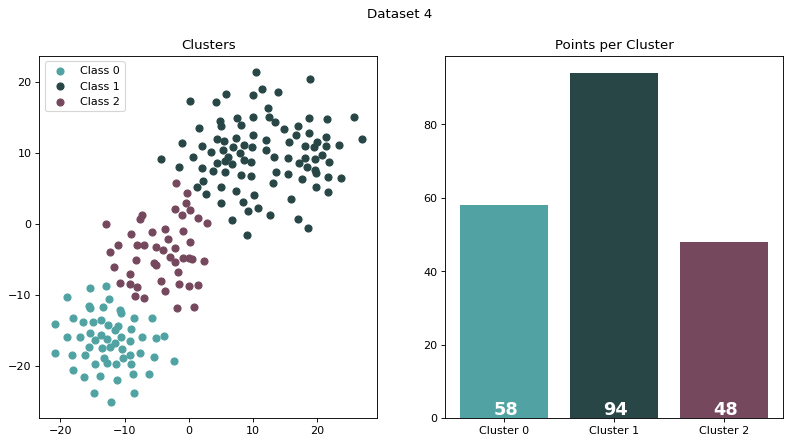

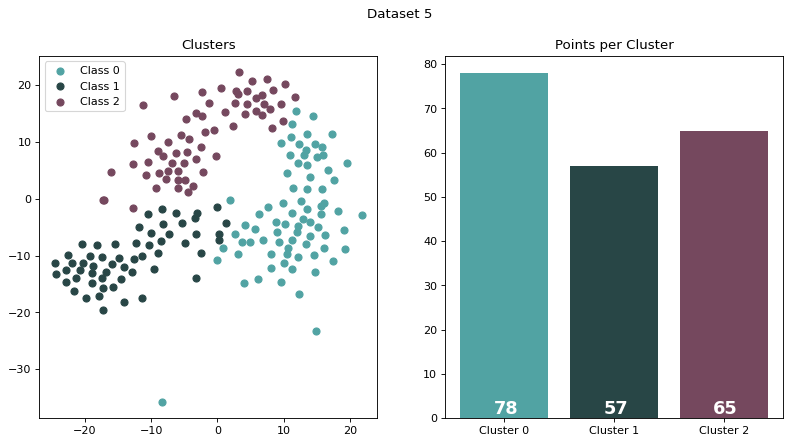

In [16]:
for index,X in enumerate(principalDf):
    gmm = mixture.GaussianMixture(n_components=3, covariance_type='full', random_state=42).fit(X)
    # Assign a label to each sample 
    labels = gmm.predict(X) 
    X['labels']= labels 

    fig, axs = plt.subplots(1,2,figsize=(12, 6), dpi=80)

    myColorMap = ['#51A3A3', '#284646', '#75485E', '#CB904D']
    for i in range(3):
        X_array = np.array(X.loc[X['labels'] == i])
        axs[0].scatter(X_array[:, 0], X_array[:, 1], c=myColorMap[i], s=40, label = "Class "+str(i));
    axs[0].legend()
    axs[0].set_title("Clusters")

    d0 = X[X['labels']== 0] 
    d1 = X[X['labels']== 1] 
    d2 = X[X['labels']== 2] 

    # Histogram Visualization
    values = [d0.shape[0], d1.shape[0],d2.shape[0]]
    classes = ('Cluster 0', 'Cluster 1', 'Cluster 2')
    x_pos = np.arange(len(classes))
    # Create classes with different colors
    axs[1].bar(x_pos, values, color=myColorMap)
    # Create names on the x-axis
    axs[1].set_xticks(x_pos)
    axs[1].set_xticklabels(classes)
    axs[1].set_title("Points per Cluster")
    for i, bar in enumerate(values):
        plt.text(i-.10, 1 , bar, fontsize=16, color ='white', fontweight='bold')

    plt.suptitle("Dataset "+ str(index+1))
    plt.show()
    print("\n")

# UMAP

### Hypertuning: *n_neighbors*

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


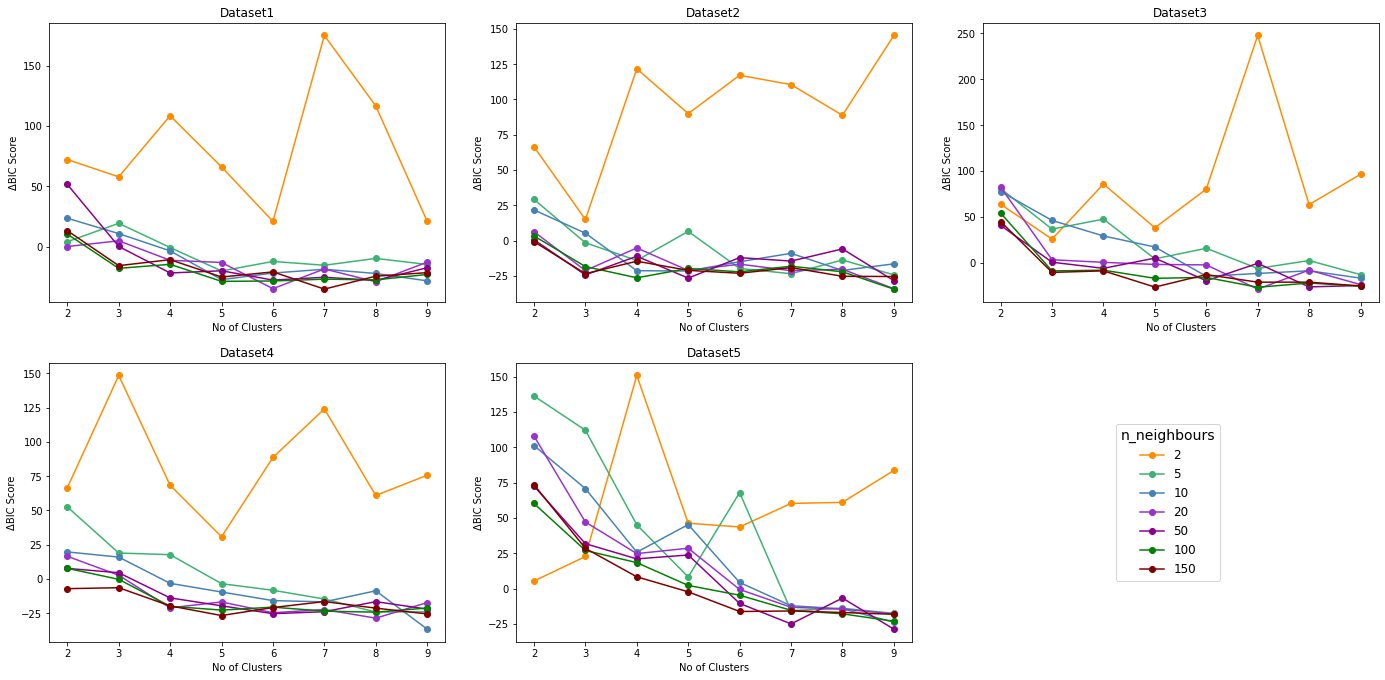

In [17]:
n_neighbors = [2, 5, 10, 20, 50, 100, 150]

# Plot the BIC scores
fig, ax = plt.subplots(2, 3 ,figsize=(20,10))
colormap = ['darkorange', 'mediumseagreen','steelblue','darkorchid','darkmagenta', 'green','maroon']
fig.tight_layout(pad=4.0)
fig.delaxes(ax[1][2])

#LOOP Through datasets
for i in range(len(data)):
    data_reduced = []

    if i < 3:
        plot_row = 0
        plot_col = i 
    else: 
        plot_row = 1
        plot_col = i - 3

    # LOOP through Components
    for j in range(len(n_neighbors)):
        embedding = umap.UMAP(n_neighbors=n_neighbors[j]).fit_transform(data[i])
        data_reduced.append(embedding)

        column_names = []
        for k in range(data_reduced[j].shape[1]):
            column_names.append('principal component ' + str(k))

        X = pd.DataFrame(data = data_reduced[j], columns = column_names)
        
        # Set up a range of cluster numbers to try
        n_range = range(2,11)
        # Create empty lists to store the BIC and AIC values
        bic_score = []
        # Loop through the range and fit a model
        for n in n_range:
            gm = mixture.GaussianMixture(n_components=n, random_state=123, n_init=10)
            gm.fit(X)
            # Append the BIC and AIC to the respective lists
            bic_score.append(gm.bic(X))

        delta_bic_score = []
        for x in range(len(bic_score)):
            if ( x == len(bic_score)-1):
                break
            delta_bic_score.append(bic_score[x] - bic_score[x+1])

        n_range = range(2,10)
        ax[plot_row][plot_col].plot(n_range, delta_bic_score, '-o', color=colormap[j], label=str(n_neighbors[j]))

    ax[plot_row][plot_col].set(xlabel='No of Clusters', ylabel='ΔBIC Score')
    ax[plot_row][plot_col].set_xticks(n_range)    
    ax[plot_row][plot_col].set_title('Dataset'+ str(i + 1))
    if plot_row and plot_col:
        ax[plot_row][plot_col].legend(title = "n_neighbours", loc='center left', bbox_to_anchor=(1.5, 0.5), fontsize=12, title_fontsize=14)

### Hypertuning: *min_dist*

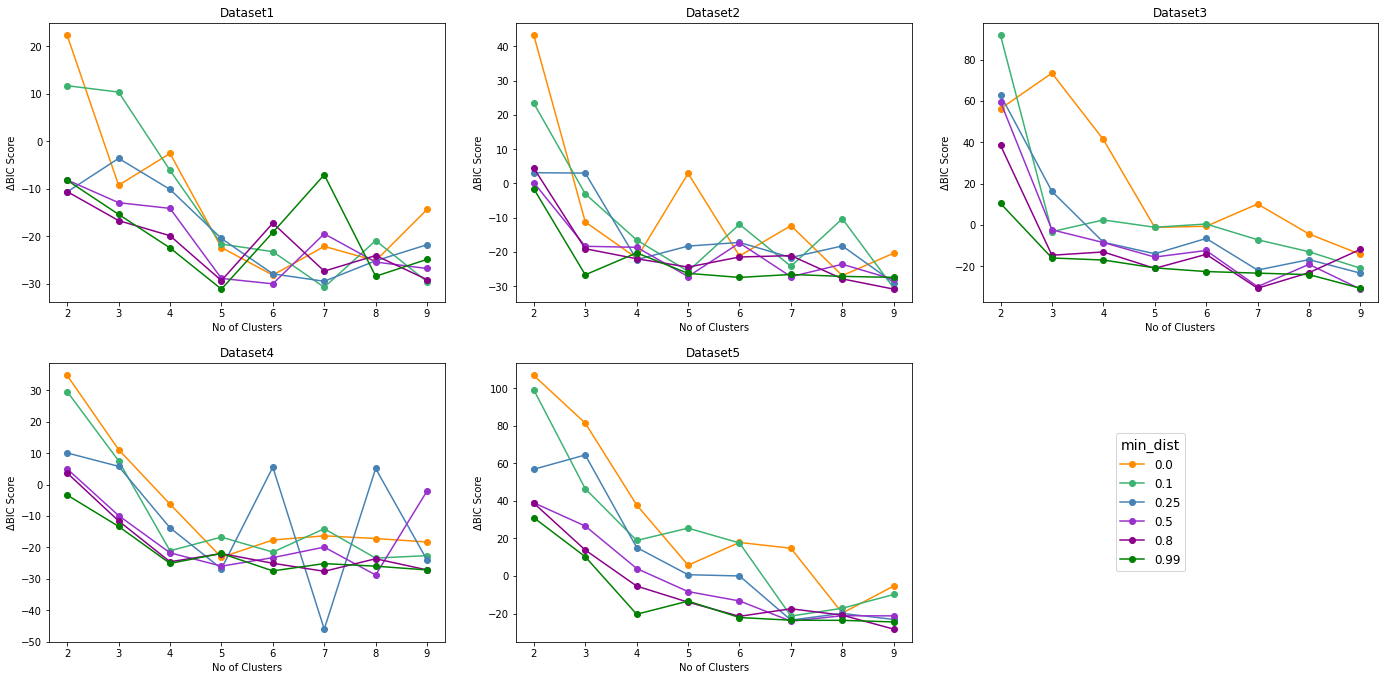

In [18]:
min_dist = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

# Plot the BIC scores
fig, ax = plt.subplots(2, 3 ,figsize=(20,10))
colormap = ['darkorange', 'mediumseagreen','steelblue','darkorchid','darkmagenta', 'green','maroon']
fig.tight_layout(pad=4.0)
fig.delaxes(ax[1][2])

#LOOP Through datasets
for i in range(len(data)):
    data_reduced = []

    if i < 3:
        plot_row = 0
        plot_col = i 
    else: 
        plot_row = 1
        plot_col = i - 3

    # LOOP through Components
    for j in range(len(min_dist)):
        embedding = umap.UMAP(min_dist=min_dist[j]).fit_transform(data[i])
        data_reduced.append(embedding)

        column_names = []
        for k in range(data_reduced[j].shape[1]):
            column_names.append('principal component ' + str(k))

        X = pd.DataFrame(data = data_reduced[j], columns = column_names)
        
        # Set up a range of cluster numbers to try
        n_range = range(2,11)
        # Create empty lists to store the BIC and AIC values
        bic_score = []
        # Loop through the range and fit a model
        for n in n_range:
            gm = mixture.GaussianMixture(n_components=n, random_state=123, n_init=10)
            gm.fit(X)
            # Append the BIC and AIC to the respective lists
            bic_score.append(gm.bic(X))

        delta_bic_score = []
        for x in range(len(bic_score)):
            if ( x == len(bic_score)-1):
                break
            delta_bic_score.append(bic_score[x] - bic_score[x+1])

        n_range = range(2,10)
        ax[plot_row][plot_col].plot(n_range, delta_bic_score, '-o', color=colormap[j], label=str(min_dist[j]))

    ax[plot_row][plot_col].set(xlabel='No of Clusters', ylabel='ΔBIC Score')
    ax[plot_row][plot_col].set_xticks(n_range)    
    ax[plot_row][plot_col].set_title('Dataset'+ str(i + 1))
    if plot_row and plot_col:
        ax[plot_row][plot_col].legend(title = "min_dist", loc='center left', bbox_to_anchor=(1.5, 0.5), fontsize=12, title_fontsize=14)

Apply UMAP to all datasets with the optimal n_neigbours (=100) and min_dist (=0.8)

In [19]:
opt_neigbours = 100
opt_min_dist = 0.8

data_reduced = []
for i in range(len(data)):
    embedding = umap.UMAP(n_neighbors=opt_neigbours,min_dist=opt_min_dist).fit_transform(data[i])

    data_reduced.append(embedding)

Transform to dataframes

In [20]:
  principalDf = []
  for i in range(len(data_reduced)):
    column_names = []

    for j in range(2):
        column_names.append('principal component ' + str(j))
        
    principalDf.append(pd.DataFrame(data = data_reduced[i], columns = column_names))

### GMM

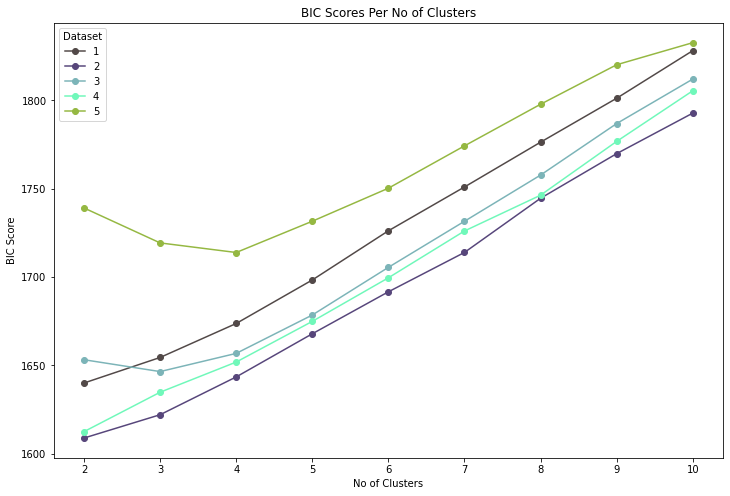

In [21]:
X = principalDf

# Set up a range of cluster numbers to try
n_range = range(2,11)
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
colormap = ['#524948', '#57467B','#7CB4B8','#70F8BA','#95b842']

for i in range(len(principalDf)):
    # Create empty lists to store the BIC and AIC values
    bic_score = []

    # Loop through the range and fit a model
    for n in n_range:
        gm = mixture.GaussianMixture(n_components=n, random_state=123, n_init=10)
        gm.fit(X[i])
        
        # Append the BIC and AIC to the respective lists
        bic_score.append(gm.bic(X[i]))

    # Plot the BIC scores
    ax.plot(n_range, bic_score, '-o', color=colormap[i], label = str(i+1))

ax.set(xlabel='No of Clusters', ylabel='BIC Score')
ax.set_xticks(n_range)
ax.set_title('BIC Scores Per No of Clusters')
ax.legend(title="Dataset")

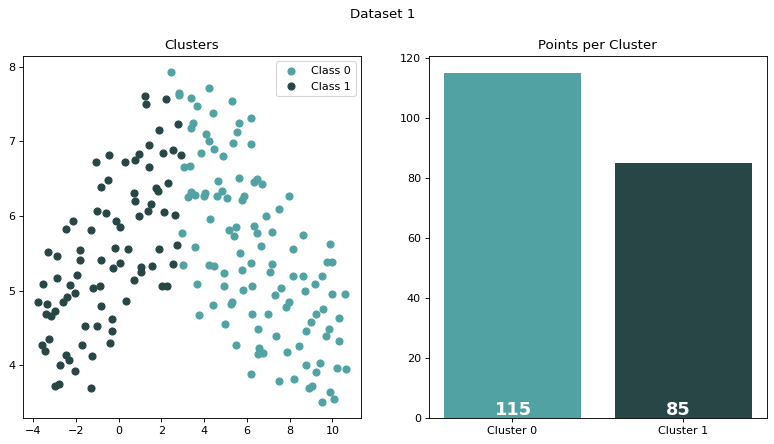

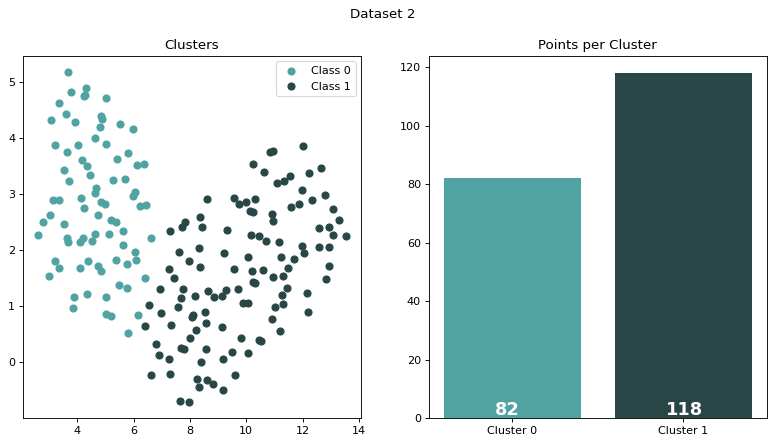

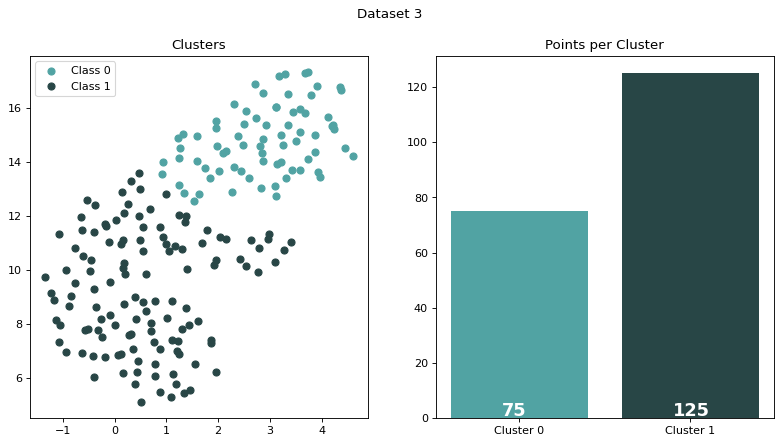

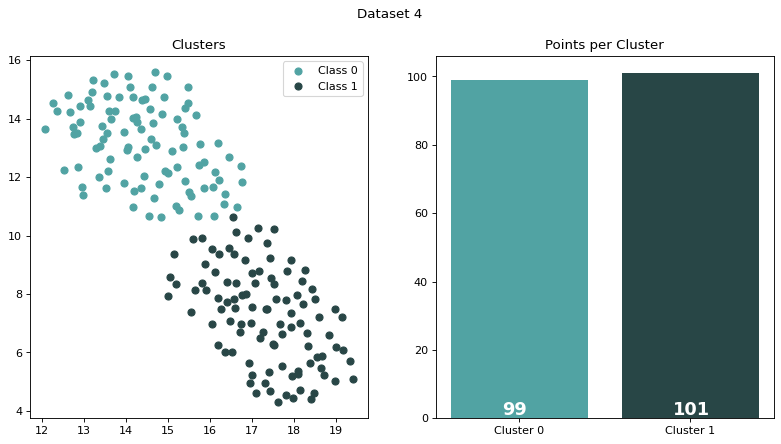

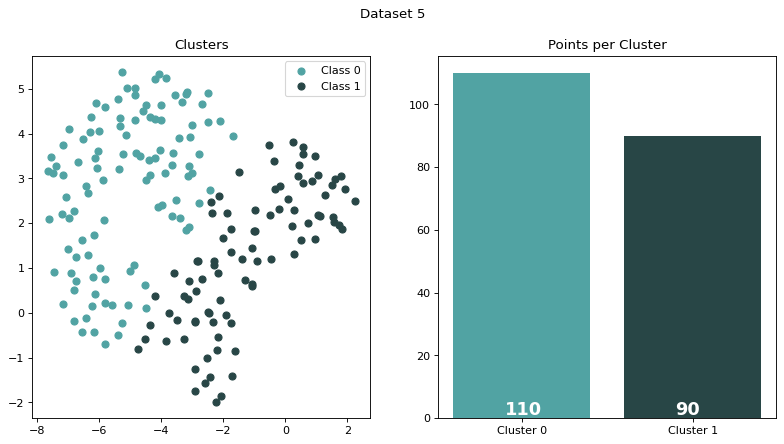

In [22]:
for index,X in enumerate(principalDf):
    gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit(X)
    # Assign a label to each sample 
    labels = gmm.predict(X) 
    X['labels']= labels 

    fig, axs = plt.subplots(1,2,figsize=(12, 6), dpi=80)

    myColorMap = ['#51A3A3', '#284646']
    for i in range(2):
        X_array = np.array(X.loc[X['labels'] == i])
        axs[0].scatter(X_array[:, 0], X_array[:, 1], c=myColorMap[i], s=40, label = "Class "+str(i));
    axs[0].legend()
    axs[0].set_title("Clusters")

    d0 = X[X['labels']== 0] 
    d1 = X[X['labels']== 1] 

    # Histogram Visualization
    values = [d0.shape[0], d1.shape[0]]
    classes = ('Cluster 0', 'Cluster 1')
    x_pos = np.arange(len(classes))
    # Create classes with different colors
    axs[1].bar(x_pos, values, color=myColorMap)
    # Create names on the x-axis
    axs[1].set_xticks(x_pos)
    axs[1].set_xticklabels(classes)
    axs[1].set_title("Points per Cluster")
    for i, bar in enumerate(values):
        plt.text(i-.10, 1 , bar, fontsize=16, color ='white', fontweight='bold')

    plt.suptitle("Dataset "+ str(index+1))
    plt.show()
    print("\n")